In [ ]:
# !pip install --upgrade tensorflow

In [ ]:
# Step 1: Pytorch and Training Metadata
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import os
from pathlib import Path
from torch import no_grad
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from keras.applications import ImageDataGenerator

#hyperparameters
batch_size = 128
epochs = 10
lr = 0.001
try_cuda = True
seed = 1000

# Architecture
num_classes = 10

#otherum
logging_interval = 10 # how many batches to wait before logging
logging_dir = None
grayscale = True

In [ ]:
# 1) setting up the logging

datetime_str = datetime.now().strftime('%b%d_%H-%M-%S')

if logging_dir is None:
    runs_dir = Path("./") / Path(f"runs/")
    runs_dir.mkdir(exist_ok = True)

    logging_dir = runs_dir / Path(f"{datetime_str}")

    logging_dir.mkdir(exist_ok = True)
    logging_dir = str(logging_dir.absolute())

writer = SummaryWriter(log_dir=logging_dir)  # tensorboard

#deciding whether to send to the cpu or not if available
if torch.cuda.is_available() and try_cuda:
    cuda = True
    torch.cuda.manual_seed(seed)
else:
    cuda = False
    torch.manual_seed(seed)

print(f"GPU available is {cuda}.")
if cuda:
      print("Running on GPU.")
else:
      print("Running on CPU.")

GPU available is False.
Running on CPU.


In [ ]:
import pandas as pd
import os
from glob import glob

from google.colab import drive
drive.mount('/content/mydrive')

# Check if the directory exists before trying to access it.
dir_path = '/content/mydrive/MyDrive/ELEC576_final/Data'

# debug code when trying to setup path correctly
# if os.path.exists(dir_path):
#     os.listdir(dir_path)  # List the directory's contents
# else:
#     print(f"Directory not found: {dir_path}")  # Print an informative message

# show all the files and folders in 'Data'
#print(os.listdir('/content/mydrive/MyDrive/ELEC576_final/Data'))

# Data_Entry_2017_v2020.csv from https://nihcc.app.box.com/v/ChestXray-NIHCC/folder/36938765345 NIH CXR8 database
# has all vital information of the public available 112,120 X-RAY images with labels.
all_xray_df = pd.read_csv('/content/mydrive/MyDrive/ELEC576_final/Data/Data_Entry_2017_v2020.csv')
unique_paths = all_xray_df['Finding Labels'].unique()
print(f"Data_Entry_2017_v2020.csv is read into a df of {all_xray_df.shape}. It has {len(unique_paths)} unique 'Finding Labels'.")

# all_image_paths = {os.path.basename(x): x for x in
#                    glob(os.path.join('/content/mydrive/MyDrive/ELEC576_final/Data', 'images*', '*', '*.png'))}
#print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
# all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
print("Here are some data points from df before df cleaning up and preprocessing:")
all_xray_df.sample(3)

Mounted at /content/mydrive
Data_Entry_2017_v2020.csv is read into a df of (112120, 11). It has 836 unique 'Finding Labels'.
Here are some data points from df before df cleaning up and preprocessing:


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path
32936,00008626_004.png,No Finding,4,8626,37,M,AP,2500,2048,0.168,0.168,None
88997,00022073_000.png,Infiltration,0,22073,26,F,PA,2546,2777,0.143,0.143,None
79090,00019407_010.png,No Finding,10,19407,34,F,AP,2500,2048,0.168,0.168,None


There are 112120 images in the database.
Total percentage of the first 15 labels is 84.27%.  Below is the detail.
**** Dataset is very imbalanced -- 'No findings' data points are over 50%. ****

               Unique Labels  Counts Percentages
0                 No Finding   60361      53.84%
1               Infiltration    9547       8.51%
2                Atelectasis    4215       3.76%
3                   Effusion    3955       3.53%
4                     Nodule    2705       2.41%
5               Pneumothorax    2194       1.96%
6                       Mass    2139       1.91%
7      Effusion|Infiltration    1603       1.43%
8   Atelectasis|Infiltration    1350       1.20%
9              Consolidation    1310       1.17%
10      Atelectasis|Effusion    1165       1.04%
11        Pleural_Thickening    1126       1.00%
12              Cardiomegaly    1093       0.97%
13                 Emphysema     892       0.80%
14       Infiltration|Nodule     829       0.74%



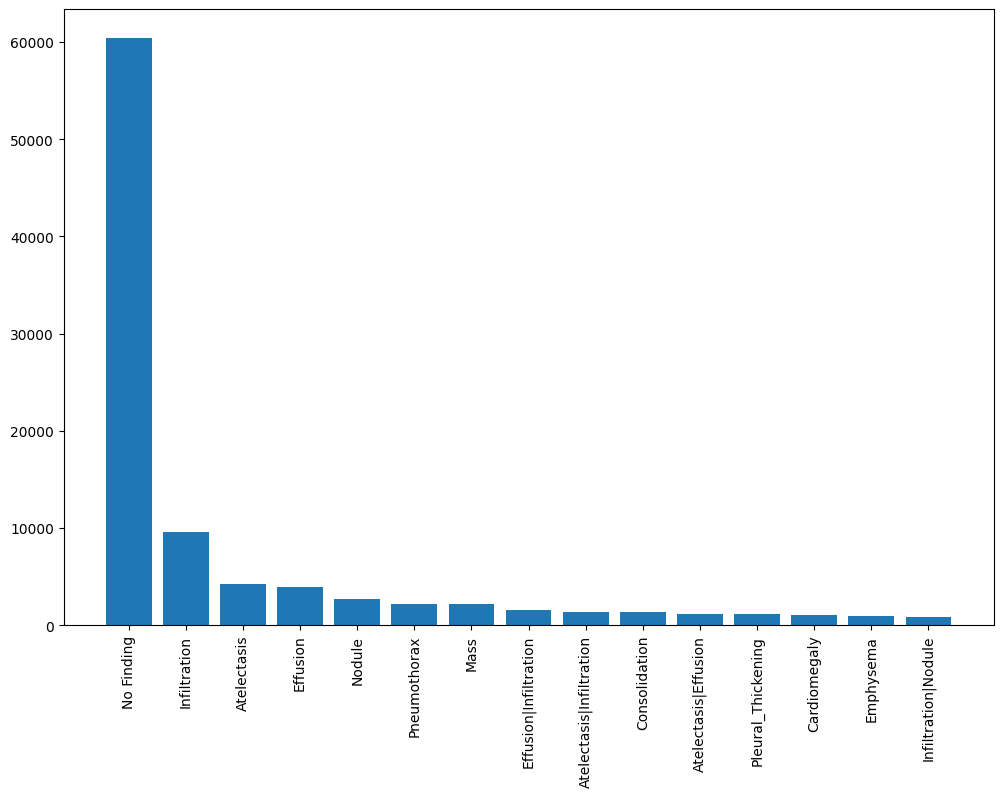

In [ ]:
import matplotlib.pyplot as plt # Importing the matplotlib.pyplot module
import numpy as np # Importing the numpy module

label_counts = all_xray_df['Finding Labels'].value_counts()[:15]

# Calculate the total number of observations
total_observations = len(all_xray_df)
print(f"There are {total_observations} images in the database.")

# Calculate the percentages
label_percentages = (label_counts / total_observations) * 100
# Calculate the total percentage of the top 15 labels
total_percentage = label_percentages.sum()
# Print the total percentage with 2 decimal places and % sign
print(f"Total percentage of the first 15 labels is {total_percentage:.2f}%.  Below is the detail.")
print("**** Dataset is very imbalanced -- 'No findings' data points are over 50%. ****\n")

label_with_info = []
for label, count in label_counts.items():
    percentage = (count / total_observations) * 100
    label_with_info.append(f"{label} ({count}, {percentage:.2f}%)")  # Use f-string for formatting

# Create a DataFrame from label_with_info
table_data = []
for label_info in label_with_info:
    label, info = label_info.split(" (")  # Split into label and (count, percentage)
    count, percentage = info[:-1].split(", ")  # Split info into count and percentage
    table_data.append([label, int(count), percentage])

df = pd.DataFrame(table_data, columns=["Unique Labels", "Counts", "Percentages"])

# Display the table
print(f"{df}\n")

fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [ ]:
# preprocessing labels.

# from itertools import chain

all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))

# one-hot encode the 'Finding Labels' column
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

# keep at least 1000 cases
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if all_xray_df[c_label].sum()>MIN_CASES]
print("Total data entries in the dataset before getting rid of all cases that have occurrences of 1000 or less :", f"{len(all_xray_df):,}")
total_cases = sum([all_xray_df[c_label].sum() for c_label in all_labels])
percentage = total_cases/len(all_xray_df)*100
print("Total data entries in the dataset after getting rid of all cases that have occurence of 1000 or less :  ", f"{int(total_cases):,}")
print(f"Percentage of data entries kept in dataset df (after dropping rare occurrences) : {percentage:.2f}%\n")

print('All Labels after dropping ({}) :\n'.format(len(all_labels)),
      [(c_label,int(all_xray_df[c_label].sum())) for c_label in all_labels])

# empty_label_count = all_xray_df['Finding Labels'].eq('').sum()
# print(f"Number of empty labels: {empty_label_count}")

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
Total data entries in the dataset before getting rid of all cases that have occurrences of 1000 or less : 112,120
Total data entries in the dataset after getting rid of all cases that have occurence of 1000 or less :   80,949
Percentage of data entries kept in dataset df (after dropping rare occurrences) : 72.20%

All Labels after dropping (13) :
 [('Atelectasis', 11559), ('Cardiomegaly', 2776), ('Consolidation', 4667), ('Edema', 2303), ('Effusion', 13317), ('Emphysema', 2516), ('Fibrosis', 1686), ('Infiltration', 19894), ('Mass', 5782), ('Nodule', 6331), ('Pleural_Thickening', 3385), ('Pneumonia', 1431), ('Pneumothorax', 5302)]


**Purpose**: This code calculates sample weights for the rows in all_xray_df. These weights can be used to address class imbalance in the dataset during the model training process.

**Step-by-step explanation**:

**sample_weights = all_xray_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2**:
This line calculates the initial sample weights:

**all_xray_df['Finding Labels'].map(...)**:
This applies a function to each value in the 'Finding Labels' column.

**lambda x: len(x.split('|')) if len(x)>0 else 0**:
This lambda function checks the length of the 'Finding Labels' string (x). If the length is greater than 0 (meaning there are findings), it splits the string by the '|' character and counts the number of findings. If the length is 0 (no findings), it assigns a weight of 0.
.values: This extracts the calculated weights as a NumPy array.

**+ 4e-2**: This adds a small constant (0.04) to all weights.
This is likely done to avoid having weights of 0, which could cause issues during training.
**sample_weights /= sample_weights.sum()**: This line normalizes the weights:
/=: This is a shorthand for dividing sample_weights by the sum of all weights and assigning the result back to sample_weights. This ensures that the weights sum to 1, effectively turning them into probabilities.
In simpler terms:

The code assigns higher weights to samples (rows in the DataFrame) that have more findings listed in the 'Finding Labels' column. **This is a way to give more importance to samples with multiple conditions during training, potentially improving the model's ability to learn from these complex cases. The weights are then normalized to ensure they represent probabilities.**

**Why is this important?**

In medical datasets, it's common to have class imbalance, where some conditions are much more prevalent than others. This can lead to a model that is biased towards the majority class. Sample weights can help to mitigate this issue by giving more importance to the minority classes during training, leading to a more balanced and accurate model.

The dataset df is randomly sampled and reduced to  10000 data points.
The dataset shape: (10000, 26). Its 26 columns are:
Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'path', 'Atelectasis',
       'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema',
       'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule',
       'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'],
      dtype='object')


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
96221,00025304_002.png,Atelectasis|Effusion,2,25304,21,M,PA,2992,2991,0.143000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100362,00026597_008.png,Effusion|Infiltration,10,26597,45,M,PA,2021,2021,0.194311,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
81019,00019899_009.png,Atelectasis|Consolidation|Effusion,9,19899,64,M,AP,2500,2048,0.168000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


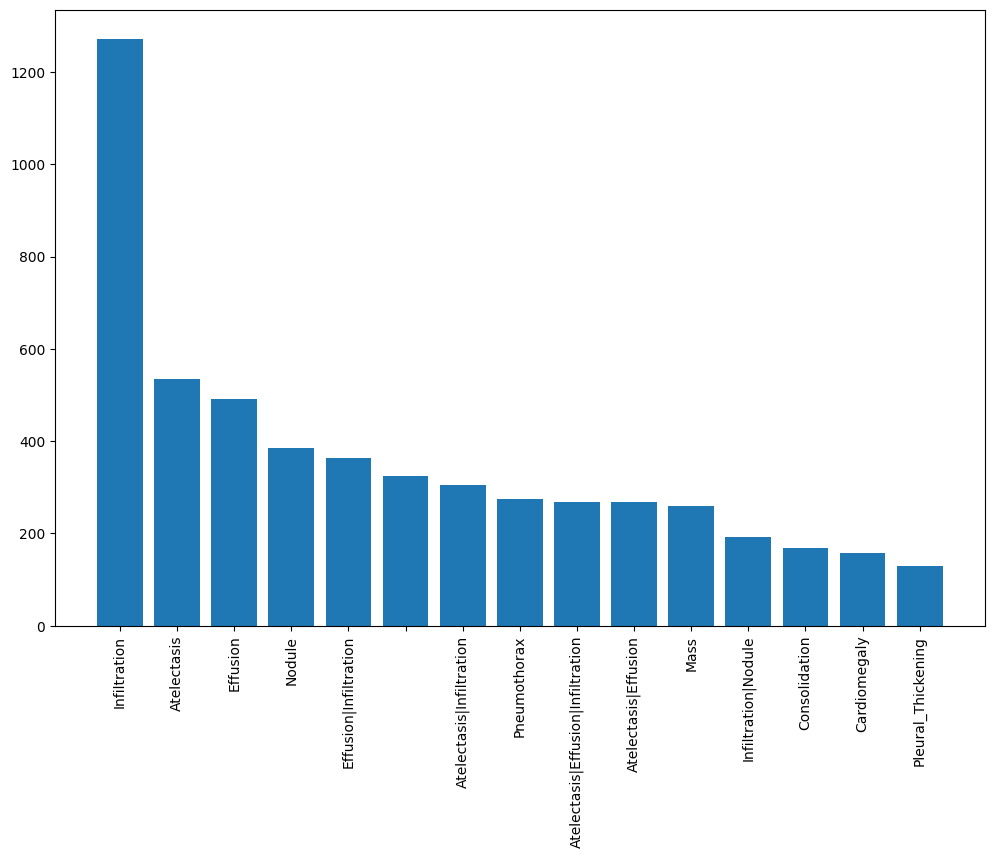

In [ ]:
# since the dataset is very unbiased, we can resample it to be a more reasonable collection
# weight is 0.1 + number of findings
sample_weights = all_xray_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()  #nomalization
#all_xray_df = all_xray_df.sample(40000, weights=sample_weights)
#all_xray_df = all_xray_df.sample(1000, weights=sample_weights)
all_xray_df = all_xray_df.sample(10000, weights=sample_weights)

print("The dataset df is randomly sampled and reduced to ", f"{len(all_xray_df)} data points.")
print(f"The dataset shape: {all_xray_df.shape}. Its {len(all_xray_df.columns)} columns are:\n{all_xray_df.columns}")

# the 'path' column specifies where the image png file locates.

label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

all_xray_df.sample(3)

In [ ]:
#add the column to the image predicts,  a single vector (disease_vec) with the 0/1 outputs for the disease status (what the model will try and predict)
all_xray_df['disease_vec'] = all_xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

In [ ]:
# Set display options to show all columns and rows without truncation
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows
pd.set_option('display.max_colwidth', None) # Show full column width

print(all_xray_df['disease_vec'].sample(3))
print(all_xray_df.shape)

51859    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0]
31304    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
85912    [1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Name: disease_vec, dtype: object
(10000, 27)


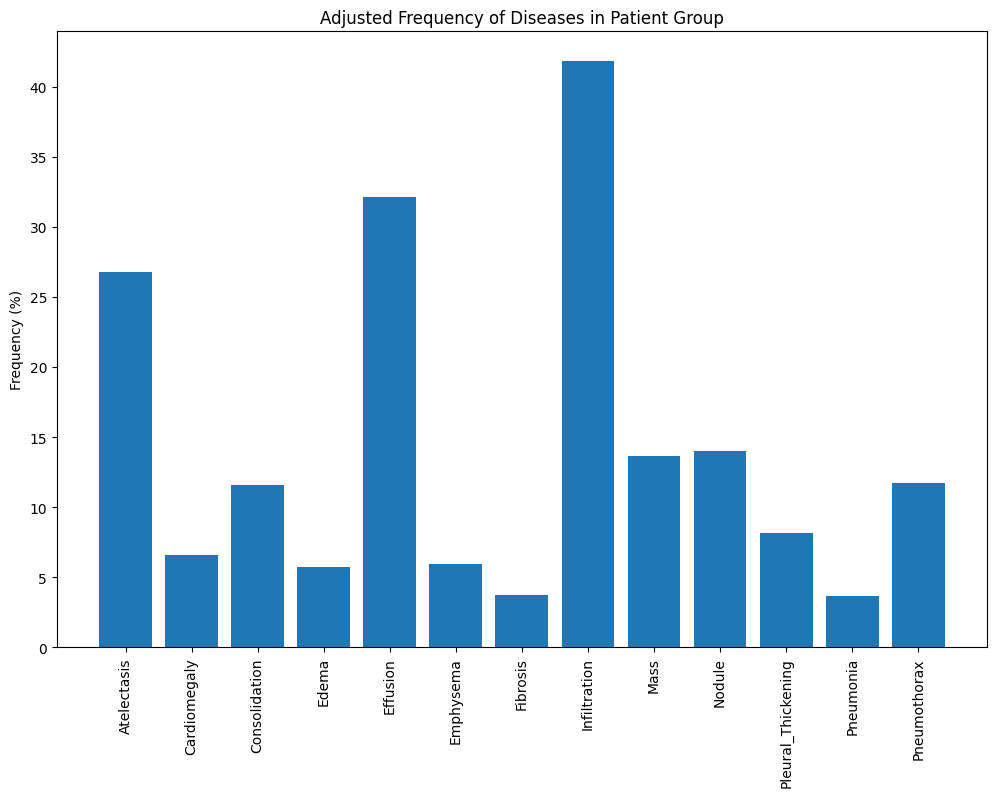

In [ ]:
#this code calculates the frequencies of diseases from patient data,
#then visualizes those frequencies as a bar chart with appropriate labels and titles.

label_counts = 100*np.mean(all_xray_df[all_labels].values,0)
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
ax1.set_xticklabels(all_labels, rotation = 90)

ax1.set_title('Adjusted Frequency of Diseases in Patient Group')
_ = ax1.set_ylabel('Frequency (%)')

In [ ]:
# complete the path information for each image.
#print(all_xray_df.columns)
print(all_xray_df['path'].sample(2))  # Print 2 sample paths

all_image_paths = {os.path.basename(x): x for x in
                   glob(os.path.join('/content/mydrive/MyDrive/ELEC576/Data', 'images*', '*.png'))}

# debugging 'path'
#                   glob(os.path.join('/content/mydrive/MyDrive/ELEC576/Data', 'images*', '*', '*.png'))}

# import itertools  # for islice if needed
# # Print the first 10 items (adjust as needed)
# for key, value in itertools.islice(all_image_paths.items(), 10):
#     print(f"Key: {key}, Value: {value}")

print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df['Patient Age'] = all_xray_df['Patient Age'].astype(int)
#print(all_xray_df.sample(3))
print(all_xray_df.shape)

# Check for null paths (which indicate missing files) and drop them
all_xray_df = all_xray_df.dropna(subset=['path'])

print("After dropping null paths:")
print(all_xray_df.shape)

# Check for empty strings in the 'path' column
empty_paths = all_xray_df[all_xray_df['path'] == '']

# Print the number of empty paths
print(f"Number of empty paths: {len(empty_paths)}")

# Optionally, print the rows with empty paths
if all_xray_df['path'].isnull().any() == True:
  print("problem!!!")
else:
  print("no problem")

45102    None
20006    None
Name: path, dtype: object
Scans found: 112178 , Total Headers 10000
(10000, 27)
After dropping null paths:
(10000, 27)
Number of empty paths: 0
no problem


In [ ]:
# # - download the data
# # - create the pytorch datasets
# #     scaling
# # - create pytorch dataloaders
# #     transforms
# #     batch size

# #normalize = transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5,0.5,0.5])
# normalize = transforms.Normalize(mean = [0.5], std = [0.5])
# transform = transforms.Compose(
#     [transforms.RandomHorizontalFlip(),
#      #transforms.RandomCrop(size = 28, padding = [0,2,3,4]),
#      transforms.RandomCrop(size = 28),
#      transforms.Grayscale(num_output_channels=1),
#      transforms.ToTensor(),
#      normalize])

# #train_dataset = datasets.CIFAR10(root = './CIFAR', train = True, transform = transform, download = True)
# #test_dataset = datasets.CIFAR10(root = './CIFAR', train = False, transform = transform, download = True)
# #train_dataset = datasets.CIFAR10(root = './content/mydrive/ELEC576_final/data/images_001', train = True, transform = transform, download = True)
# test_dataset = datasets.CIFAR10(root = './/content/mydrive/ELEC576_final/data/images_001', train = False, transform = transform, download = True)
# print(train_dataset)
# print(test_dataset)

from sklearn.model_selection import train_test_split

# "stratify = all_xray_df['Finding Labels'].map(lambda x: x[:4])" is the crucial
# part for stratification. It ensures that the proportion of samples in each
# class (represented by the first 4 characters of the 'Finding Labels' column)
# is maintained in both the training and validation sets. This is important
# for imbalanced datasets to prevent one set from having a disproportionate
# number of samples from a particular class.

# Reducing dataset size increases the probability of the least populated class in
# y (output) has only 1 member, which is too few.  The minimum number of groups
# for any class cannot be less than 2 arises when using train_test_split with
# stratification.  This means that at least one of the classes (defined by the
# 'Finding Labels' column). has only one sample in your dataset after applying any
# filters or sampling. When you stratify the split, you are requesting that the
# train and test sets maintain the same proportion of samples from each class as
# the original dataset. However, if a class has only one sample, it is impossible
# to split it into two or more sets while preserving the proportions, leading to the error.

# Calculate the frequency of each unique label in the 'Finding Labels' column
label_frequencies = all_xray_df['Finding Labels'].value_counts()

# Filter out labels with only one occurrence
valid_labels = label_frequencies[label_frequencies > 1].index

# Create a boolean mask indicating rows with valid labels
valid_mask = all_xray_df['Finding Labels'].isin(valid_labels)

# Apply the mask to select only rows with valid labels
filtered_df = all_xray_df[valid_mask]

train_df, valid_df = train_test_split(all_xray_df,
                                   test_size = 0.25,
                                   random_state = 2018,
                                   stratify = all_xray_df['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

#print(all_xray_df.sample(3))
#print(train_df.sample(3))
#print(valid_df.sample(3))
print(train_df.shape)
print(valid_df.shape)
print(train_df.columns)
#print(train_df[0])

train 7500 validation 2500
(7500, 27)
(2500, 27)
Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'path', 'Atelectasis',
       'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema',
       'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule',
       'Pleural_Thickening', 'Pneumonia', 'Pneumothorax', 'disease_vec'],
      dtype='object')


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np

def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, batch_size, **dflow_args):
    """
    Creates a generator that yields batches of image data and labels from a DataFrame.

    Args:
        img_data_gen: An ImageDataGenerator instance for data augmentation.
        in_df: The DataFrame containing image paths and labels.
        path_col: The name of the DataFrame column containing image paths.
        y_col: The name of the DataFrame column containing labels.
        **dflow_args: Additional arguments for the generator (e.g., target_size, batch_size).

    Returns:
        A generator that yields batches of image data and labels.
    """

    # Get the total number of samples
    total_samples = in_df.shape[0]

    # Create an empty list to store the images and labels
    all_data_x = []
    all_data_y = []

    # Loop through each image path in the DataFrame
    for index, row in in_df.iterrows():
        img_path = row[path_col]  # Get the image path
        img = load_img(img_path, **dflow_args)  # Load the image
        img_array = img_to_array(img)  # Convert to NumPy array
        img_array = img_data_gen.random_transform(img_array)  # Apply random transformations
        img_array = img_data_gen.standardize(img_array)  # Standardize the image

        all_data_x.append(img_array)  # Append the image to the list
        all_data_y.append(row[y_col])  # Append the label to the list

    # # Convert lists to numpy array
    # all_data_x = np.array(all_data_x)
    # all_data_y = np.array(all_data_y)

    # fit() later on complains the invalid data type.  So ...
    # Convert lists to numpy array
    all_data_x = np.array(all_data_x, dtype=np.float32)  # Explicitly set dtype to float32
    all_data_y = np.array(all_data_y, dtype=np.float32)  # Explicitly set dtype to float32

    # Create a generator from the image data and labels
    # Define a function to generate batches of data
    def data_generator(X, y, batch_size):
        num_samples = X.shape[0]
        indices = np.arange(num_samples)
        while True:
            np.random.shuffle(indices)  # Shuffle the data
            for i in range(0, num_samples, batch_size):
                batch_indices = indices[i:min(i + batch_size, num_samples)]
                yield X[batch_indices], y[batch_indices]

    # Create the generator
    generator = data_generator(all_data_x, all_data_y, batch_size)

    return generator

In [ ]:
IMG_SIZE = (128, 128)
# This ImageDataGenerator is configured to perform a variety of data augmentation techniques
# on the images, including centering, normalization, flipping, shifting, rotation,
# shearing, and zooming. These transformations help create a more diverse training dataset,
# which can lead to better generalization performance of your deep learning model.

# If any of the parameters related to augmentation (e.g., horizontal_flip,
# rotation_range, zoom_range) are set to values other
# than their defaults (usually 0 or False), then augmentation is being applied.

core_idg = ImageDataGenerator(samplewise_center=True,
                              samplewise_std_normalization=True,
                              horizontal_flip = True,
                              vertical_flip = False,
                              height_shift_range= 0.05,
                              width_shift_range=0.1,
                              rotation_range=5,
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

# below is without augmentataion.
# core_idg = ImageDataGenerator(samplewise_center=True,
#                               samplewise_std_normalization=True,
#                               horizontal_flip = False, #= True,
#                               vertical_flip = False,
#                               height_shift_range = 0.0, #= 0.05,
#                               width_shift_range = 0.0, # =0.1,
#                               rotation_range = 0, # =5,
#                               shear_range = 0, # = 0.1,
#                               fill_mode = 'nearest', # 'reflect',
#                               zoom_range = 0) #=0.15)

In [ ]:
# create the training data generator for the training images.
train_gen = flow_from_dataframe(core_idg,
                                train_df,
                                path_col = 'path',
                                y_col = 'disease_vec',
                                batch_size = 32,
                                target_size = IMG_SIZE,
                                color_mode = 'grayscale'
                                )
# Below is all debugging code when trying to use data flow from directory module.
# i = 0
# for filename in train_gen.filenames:
#       i = i + 1
#       # if len(filename) < len("/content/mydrive/MyDrive/ELEC576/Data/images_012/00028974_024.png"):
#       #   print("Problem", filename)
#       #   break
#       if i %1000 == 0:
#         print(f"{i}:")
#         try:
#             print(f"filename: {filename}")
#  #           image = Image.open(filename)
#  #           print("Image opened successfully")
#             # ... process the image ...
#         except Exception as e:
#             print("Error Loading Image:", filename, e)

# Print the batch shape to confirm the batch size
#t_x, t_y = next(train_gen)
#print("Batch Shape:", t_x.shape, t_y.shape)

# Check a sample image path
# sample_path = train_df['path'].iloc[0]  # Adjust the index as needed
# print("Sample Path:", sample_path)
# print("Path Exists:", os.path.exists(sample_path))

# print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
# #print(train_gen.filenames)
# print(f"train_gen.filenames len: len(train_gen.filenames)")
# print(f"train_gen.filepaths: {train_gen.filepaths}")
# print(f"train_gen.filepaths length", len(train_gen.filepaths))
# print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")

# create training datasets X and y
# start_index = train_gen.batch_index * train_gen.batch_size
# start_index = train_gen.filepaths

# from tensorflow.keras.utils import load_img  # Import load_img
# print(f"train_gen shape: {train_gen.index_array.shape}")

# for i, j in enumerate(train_gen.index_array):
#   print("******************************************************")
#   print(f"i, j: {i}, {j}")
#   print(f"train_gen.index_array[i]: {train_gen.index_array[i]}")
#   if j == train_gen.index_array[i]:
#     print("j is the output of enumeration of train_gen.index_array")
#   else:
#     print("j is not the output of enumeration of train_gen.index_array")

#   target_index = j  # The number to find
#   positions = np.where(train_gen.index_array == target_index)[0]
#   if positions.size > 0:
#       print(f"The index {target_index} is found at position(s): {positions}")
#   else:
#       print(f"The index {target_index} is not found in index_array.")

#   if i == 10:
#     break

# print(f"train_gen.filepaths: {train_gen.filepaths}")

# iter = 0
# for j in range(30000):
#   print(f"train_gen.index_array[j]: {train_gen.filepaths_new[j]}")
#   iter += 1
#   if iter == 10:
#     break

  #img = load_img(train_gen.filepaths[j])

# end_index = min(start_index + train_gen.batch_size, train_gen.n)

# print("Starting index:", start_index)
# print("Ending index:", end_index)
# print("Batch size:", train_gen.batch_size)
# print("Total samples:", train_gen.n)

# t_x, t_y = next(train_gen)

# all_data_x = []
# all_data_y = []

# for batch_x, batch_y in train_gen:
#     print("Batch Shape:", batch_x.shape, batch_y.shape)
#     all_data_x.append(batch_x)
#     all_data_y.append(batch_y)

# # Concatenate the batches into a single dataset
# all_data_x = np.concatenate(all_data_x, axis=0)  # Adjust axis if needed
# all_data_y = np.concatenate(all_data_y, axis=0)

# t_x = all_data_x
# t_y = all_data_y

# fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
# for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
#     c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
#     c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y)
#                              if n_score>0.5]))
#     c_ax.axis('off')

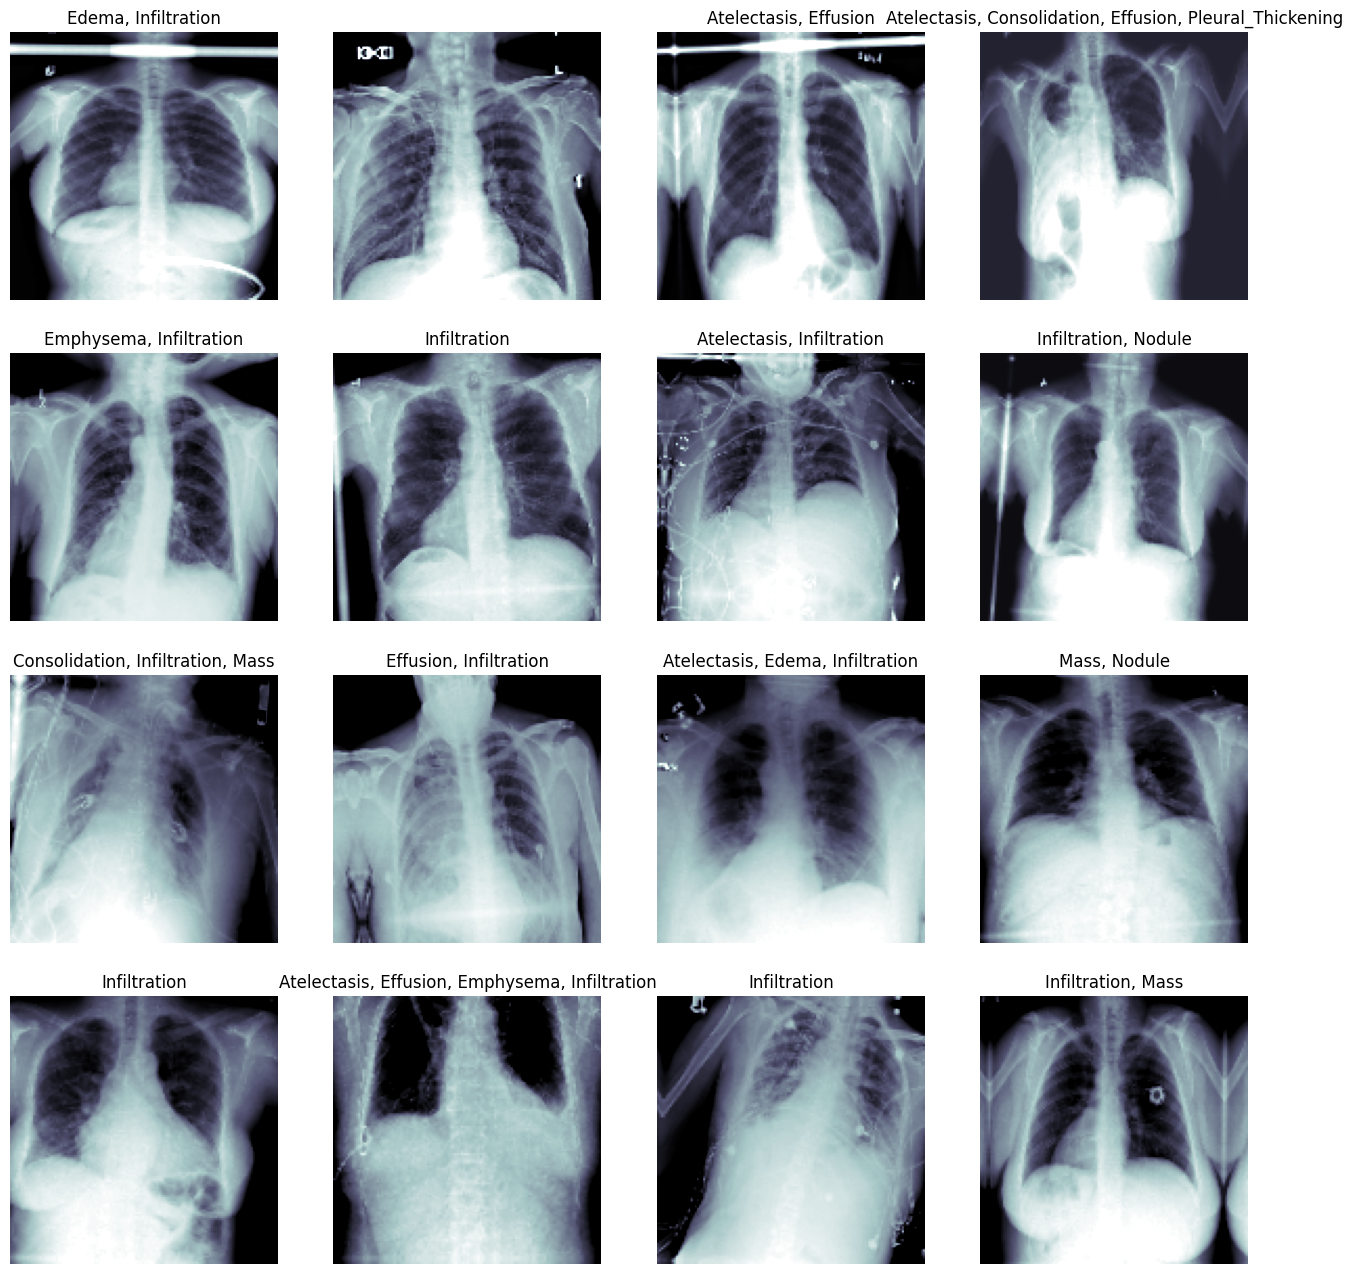

In [ ]:
# training X and training y pair obtained from training data generator.
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y)
                             if n_score>0.5]))
    c_ax.axis('off')

In [ ]:
# create the validating data generator for the validating images.
valid_gen = flow_from_dataframe(core_idg,
                                train_df,
                                path_col = 'path',
                                y_col = 'disease_vec',
                                batch_size = 256,
                                target_size = IMG_SIZE,
                                color_mode = 'grayscale'
                                )

test_X, test_Y = next(flow_from_dataframe(core_idg,
                                          valid_df,
                                          path_col = 'path',
                                          y_col = 'disease_vec',
                                          batch_size = 1024,
                                          target_size = IMG_SIZE,
                                          color_mode = 'grayscale')) # one big batch


The code below constructs a deep learning model for multi-label image classification, using MobileNet as a base and adding custom layers for classification. The model is compiled with the Adam optimizer, binary cross-entropy loss, and appropriate metrics for evaluating its performance. It is designed to predict the probability of multiple medical conditions being present in an input image.

In [ ]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
base_mobilenet_model = MobileNet(input_shape =  t_x.shape[1:],
                                 include_top = False, weights = None)
multi_disease_model = Sequential()
multi_disease_model.add(base_mobilenet_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(len(all_labels), activation = 'sigmoid'))
multi_disease_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])  # mae: mean absolute error
multi_disease_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functi  (None, 4, 4, 1024)        3228288   
 onal)                                                           
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 13)                6

**ModelCheckpoint()** sets up a mechanism to automatically save the weights of your model during training. It will only save the weights when the validation loss reaches a new minimum, ensuring you always have a copy of the best-performing model. By saving only the weights, you keep the file size smaller and maintain flexibility for loading them into different model configurations.

**EarlyStopping()** sets up a mechanism to automatically stop the training process if the model's performance on the validation set plateaus or starts to degrade. It essentially gives the model a chance to improve over a few epochs, but if it fails to do so, the training is halted to prevent overfitting and wasted time.

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

# Change the file extension to .weights.h5
weight_path = weight_path.replace(".hdf5", ".weights.h5")  # Fix: Change extension to .weights.h5

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=3)
callbacks_list = [checkpoint, early]

**multi_disease_model.fit()** initiates the training process for the multi_disease_model using the fit method in Keras. It specifies various parameters that control how the training is performed.

In [ ]:
multi_disease_model.fit(train_gen,  # Use fit instead of fit_generator
                         steps_per_epoch=100,
                         validation_data=(test_X, test_Y),
                         epochs=1,
                         callbacks=callbacks_list)

100/100 [==============================] - ETA: 0s - loss: 0.4870 - binary_accuracy: 0.8291 - mae: 0.2254
Epoch 1: val_loss improved from inf to 0.38123, saving model to xray_class_weights.best.weights.h5
100/100 [==============================] - 34s 275ms/step - loss: 0.4870 - binary_accuracy: 0.8291 - mae: 0.2254 - val_loss: 0.3812 - val_binary_accuracy: 0.8568 - val_mae: 0.2445


In [ ]:
for c_label, s_count in zip(all_labels, 100*np.mean(test_Y,0)):
    print('%s: %2.2f%%' % (c_label, s_count))

In [ ]:
pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)

In [ ]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net.png')

In [ ]:
#  In modern Keras, the fit method is used instead and it can accept data generators directly.
# multi_disease_model.fit_generator(train_gen,
#                                   steps_per_epoch = 100,
#                                   validation_data =  (test_X, test_Y),
#                                   epochs = 5,
#                                   callbacks = callbacks_list)

multi_disease_model.fit(train_gen,  # Use fit instead of fit_generator
                        steps_per_epoch = 100,
                        validation_data =  (test_X, test_Y),
                        epochs = 5,
                        callbacks = callbacks_list)

Epoch 1/5
100/100 [==============================] - ETA: 0s - loss: 0.4045 - binary_accuracy: 0.8474 - mae: 0.2212
Epoch 1: val_loss did not improve from 0.38123
100/100 [==============================] - 25s 246ms/step - loss: 0.4045 - binary_accuracy: 0.8474 - mae: 0.2212 - val_loss: 0.3901 - val_binary_accuracy: 0.8568 - val_mae: 0.1900
Epoch 2/5
100/100 [==============================] - ETA: 0s - loss: 0.3816 - binary_accuracy: 0.8495 - mae: 0.2200
Epoch 2: val_loss did not improve from 0.38123
100/100 [==============================] - 24s 242ms/step - loss: 0.3816 - binary_accuracy: 0.8495 - mae: 0.2200 - val_loss: 0.4356 - val_binary_accuracy: 0.8568 - val_mae: 0.1720
Epoch 3/5
100/100 [==============================] - ETA: 0s - loss: 0.3697 - binary_accuracy: 0.8519 - mae: 0.2181
Epoch 3: val_loss did not improve from 0.38123
100/100 [==============================] - 24s 243ms/step - loss: 0.3697 - binary_accuracy: 0.8519 - mae: 0.2181 - val_loss: 0.4785 - val_binary_accura

In [ ]:
# load the best weights
multi_disease_model.load_weights(weight_path)

In [ ]:
pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)

In [ ]:
# look at how often the algorithm predicts certain diagnoses
for c_label, p_count, t_count in zip(all_labels,
                                     100*np.mean(pred_Y,0),
                                     100*np.mean(test_Y,0)):
    print('%s: Dx: %2.2f%%, PDx: %2.2f%%' % (c_label, t_count, p_count))

In [ ]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('trained_net.png')

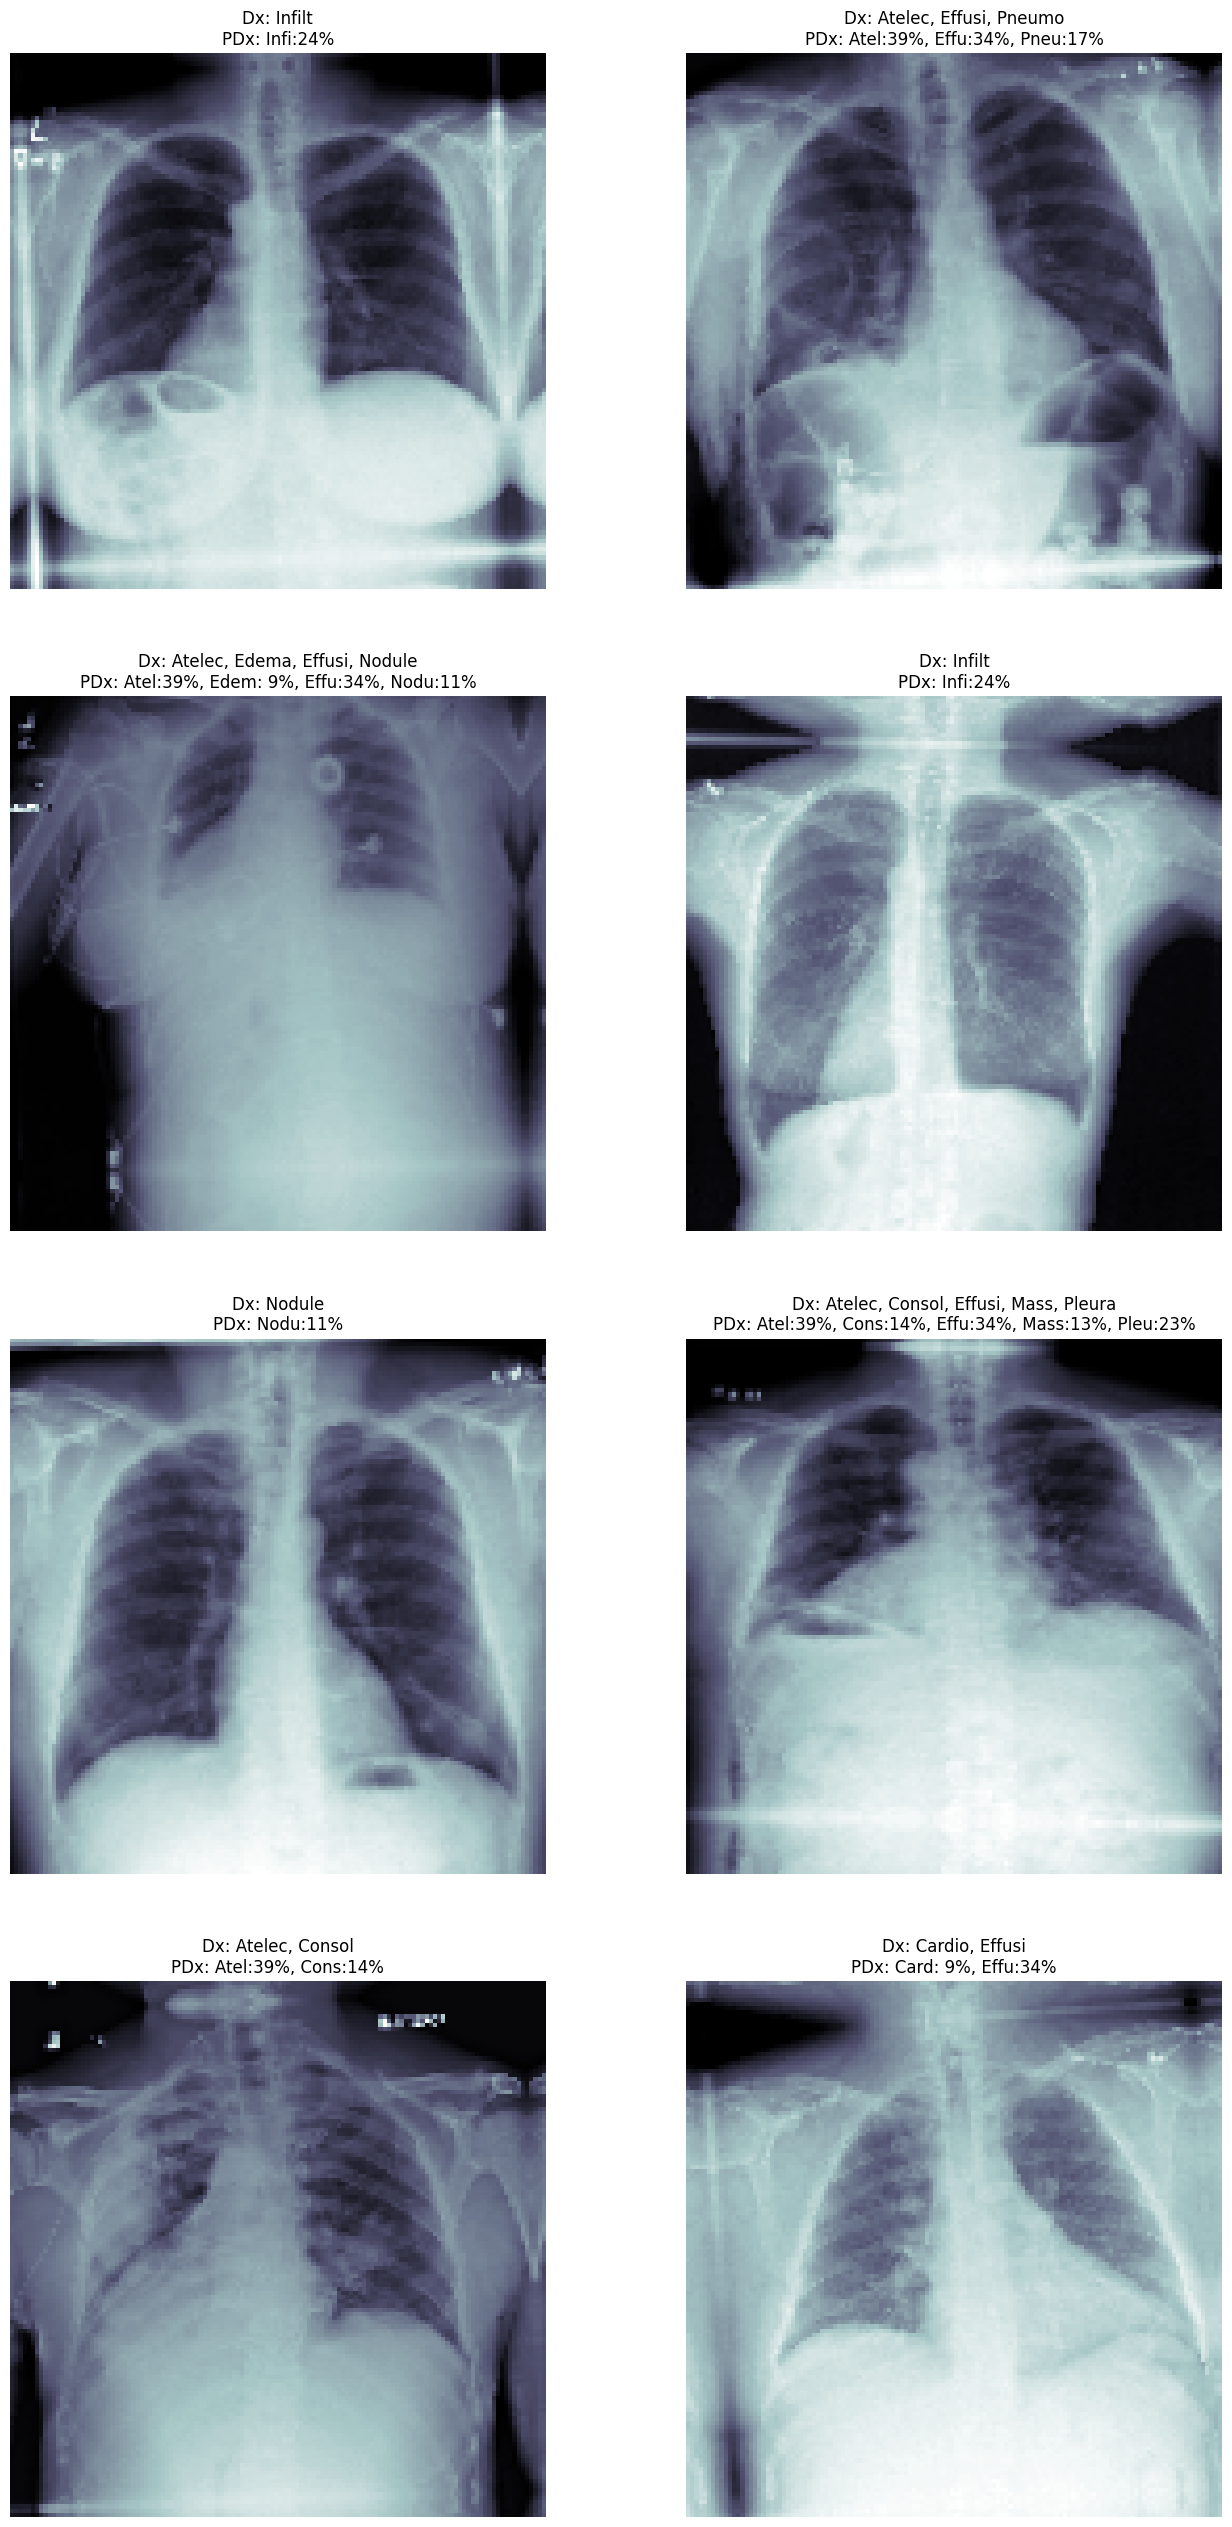

In [ ]:
sickest_idx = np.argsort(np.sum(test_Y, 1)<1)
fig, m_axs = plt.subplots(4, 2, figsize = (16, 32))
for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):
    c_ax.imshow(test_X[idx, :,:,0], cmap = 'bone')
    stat_str = [n_class[:6] for n_class, n_score in zip(all_labels,
                                                                  test_Y[idx])
                             if n_score>0.5]
    pred_str = ['%s:%2.0f%%' % (n_class[:4], p_score*100)  for n_class, n_score, p_score in zip(all_labels,
                                                                  test_Y[idx], pred_Y[idx])
                             if (n_score>0.5) or (p_score>0.5)]
    c_ax.set_title('Dx: '+', '.join(stat_str)+'\nPDx: '+', '.join(pred_str))
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png')